In [1]:
import sys
print(sys.executable)
print(sys.path)

/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/bin/python
['/uufs/chpc.utah.edu/common/home/u0035056/atmos6010/notebooks', '/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/lib/python37.zip', '/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/lib/python3.7', '/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/lib/python3.7/lib-dynload', '', '/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/lib/python3.7/site-packages', '/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/lib/python3.7/site-packages/IPython/extensions', '/uufs/chpc.utah.edu/common/home/u0035056/.ipython']


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pygrib
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import metpy.calc as mpcalc
from metpy.units import units
import windspharm
from windspharm.standard import VectorWind
from windspharm.tools import prep_data, recover_data, order_latdim
from windspharm.examples import example_data_path
from netCDF4 import Dataset
from netCDF4 import num2date
from datetime import datetime

In [3]:
# requires netcdf file 
# format: /uufs/chpc.utah.edu/common/home/u0035056/atmos_6010_2020/data/2020082200/gfs.t00z.pgrb2.1p00.f000.nc
nc_f = 'gfs.t00z.pgrb2.1p00.f000.nc'  # Your filename
path='/uufs/chpc.utah.edu/common/home/u0035056/atmos6010/data/2020092200/'
nc_fid = Dataset(path+nc_f, 'r')  # Dataset is the class behavior to open the file
# and create an instance of the ncCDF4 class
# Extract data from NetCDF file
lats = nc_fid.variables['latitude'][:]  # extract/copy the data
lons = nc_fid.variables['longitude'][:]
print(np.shape(lats))
time = nc_fid.variables['time'][:]
time_var = nc_fid.variables['time']
dtime = num2date(time_var[:],time_var.units)
date_time = dtime.tolist()
date_time = date_time[0].strftime("%Y_%m_%d_%H")
print(date_time)
# 250 hPa winds
uwnd = nc_fid.variables['UGRD_250mb'][:]  # shape is time, lat, lon as shown above
vwnd = nc_fid.variables['VGRD_250mb'][:]  # shape is time, lat, lon as shown above
nc_fid.close()
print(np.shape(uwnd))

(181,)
2020_09_22_00
(1, 181, 360)


/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  del sys.path[0]


In [4]:
#keeping just because it was part of debugging and shows maipulation of arrays
#print(np.shape(lats_all))
#lts = lats_all.flatten()
#lns = lons_all.flatten()
#uf = u5_all.flatten()
#vf = v5_all.flatten()
#print(np.shape(uf))
#uc = np.vstack((lats_all,lons_all,u5_all)).T
#vc = np.vstack((lats_all,lons_all,v5_all)).T
#print(np.shape(uc))

In [5]:
#get into right format for windspharm code for calculating the streamfunction and velocity potential
uwnd, uwnd_info = prep_data(uwnd, 'tyx')
vwnd, vwnd_info = prep_data(vwnd, 'tyx')

# It is also required that the latitude dimension is north-to-south. Again the
# bundled tools make this easy.
lats, uwnd, vwnd = order_latdim(lats, uwnd, vwnd)

# Create a VectorWind instance to handle the computation of streamfunction and
# velocity potential.
w = VectorWind(uwnd, vwnd)

In [6]:
# Compute the streamfunction and velocity potential. Also use the bundled
# tools to re-shape the outputs to the 4D shape of the wind components as they
# were read off files.
sf, vp = w.sfvp()
sf = recover_data(sf, uwnd_info)
vp = recover_data(vp, uwnd_info)

print(np.shape(sf))
#  add a cyclic point (the cyclic point for plotting purposes).
sfc, lons_c = add_cyclic_point(sf[0], lons)
vpc, lons_c = add_cyclic_point(vp[0], lons)
print(np.shape(sfc))

(1, 181, 360)
(181, 361)


In [7]:
#compute the rotation and irrotational components of the wind
uchi, vchi, upsi, vpsi = w.helmholtz()
upsi = recover_data(upsi, uwnd_info)
vpsi = recover_data(vpsi, uwnd_info)
uchi = recover_data(uchi, uwnd_info)
vchi = recover_data(vchi, uwnd_info)
#  add a cyclic point (the cyclic point for plotting purposes).
upsi, lons_c = add_cyclic_point(upsi[0], lons)
vpsi, lons_c = add_cyclic_point(vpsi[0], lons)
uchi, lons_c = add_cyclic_point(uchi[0], lons)
vchi, lons_c = add_cyclic_point(vchi[0], lons)
print(np.shape(uchi))

(181, 361)


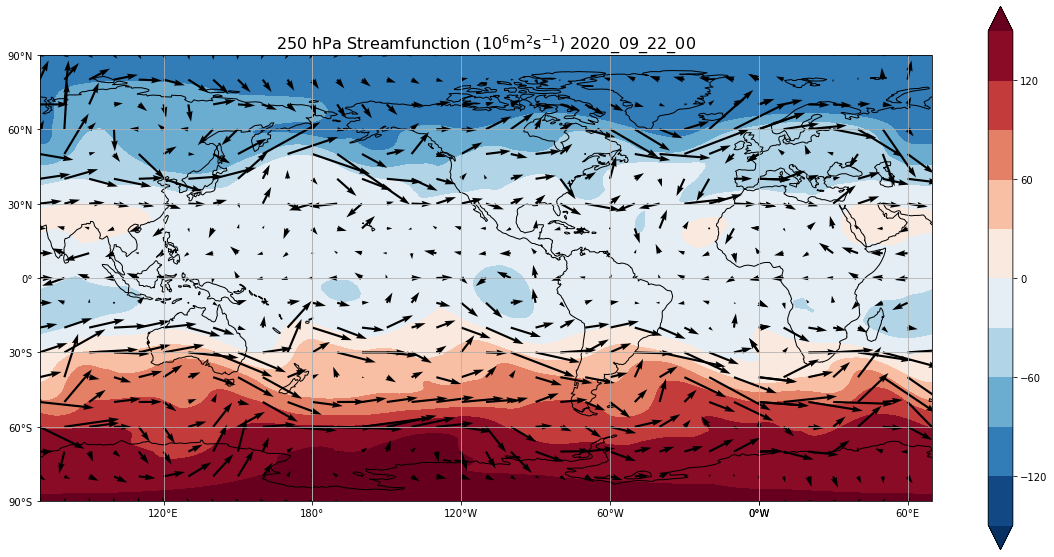

In [8]:
plt.figure(figsize=(20,10))
ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=250))
# Plot streamfunction.
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
clevs = [-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]
sf_fill = ax1.contourf(lons_c, lats, sfc * 1e-06, clevs,
                       transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r,
                       extend='both')
#plot every 10th wind vector
#for 2d arrays
skip=(slice(None,None,10),slice(None,None,10))
#for 1d arrays
skip1 = (slice(None,None,10))
plt.quiver(lons_c[skip1],lats[skip1],upsi[skip],vpsi[skip],scale=75, scale_units='inches',pivot='tail',color='black',transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines()
ax1.set_xticks([0, 60, 120, 180, 240, 300, 359.99], crs=ccrs.PlateCarree())
ax1.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True,
                                   number_format='.0f')
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
plt.colorbar(sf_fill, orientation='vertical')

plt.title('250 hPa Streamfunction ($10^6$m$^2$s$^{-1}$) %s'% date_time, fontsize=16)
plot_file = '../figs/gfs_250_streamfunction_' + date_time
plt.savefig(plot_file)

plt.show()

/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1841: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vectors(t, x, y, u, v)


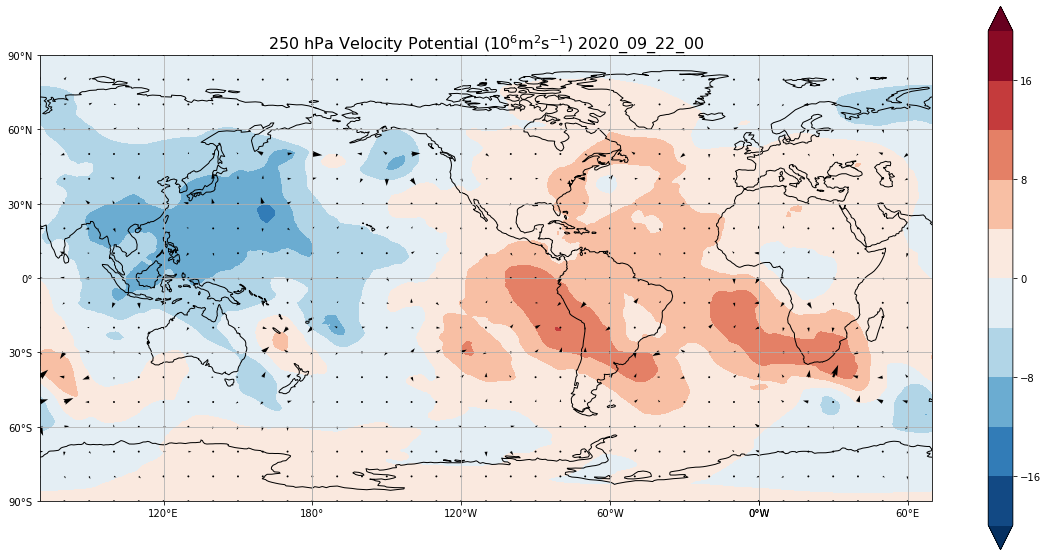

In [9]:
# Plot velocity potential.
                             
plt.figure(figsize=(20,10))
ax2 = plt.axes(projection=ccrs.PlateCarree(central_longitude=250))
clevs = [-20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20]
vp_fill = ax2.contourf(lons_c, lats, vpc * 1e-06, clevs,
                       transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r,
                       extend='both')
#plot every 10th wind vector
#for 2d arrays
skip=(slice(None,None,10),slice(None,None,10))
#for 1d arrays
skip1 = (slice(None,None,10))
plt.quiver(lons_c[skip1],lats[skip1],uchi[skip],vchi[skip],scale=75, scale_units='inches',pivot='tail',color='black',transform=ccrs.PlateCarree())
ax1.coastlines()
ax2.coastlines()
ax2.gridlines()
ax2.set_xticks([0, 60, 120, 180, 240, 300, 359.99], crs=ccrs.PlateCarree())
ax2.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True,
                                   number_format='.0f')
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
plt.colorbar(vp_fill, orientation='vertical')
plt.title('250 hPa Velocity Potential ($10^6$m$^2$s$^{-1}$) %s' % date_time, fontsize=16)
plot_file = '../figs/gfs_250_vpotential_' + date_time
plt.savefig(plot_file)
plt.show()

In [10]:
#make the data more manageable in this case for a US centric sector
#upper left corner lat/lon
ult = 70
uln = 180
#lower right corner lat/lon
rlt = 15
rln = 340
#convert lat/lons to grid indices
ulti = 90-ult
ulni = uln
rlti = 90-rlt
rlni = rln

#truncate the arrays
sft = sf[ulti:rlti,ulni:rlni]
vpt = vp[ulti:rlti,ulni:rlni]
uchit = uchi[ulti:rlti,ulni:rlni]
vchit = vchi[ulti:rlti,ulni:rlni]
uchit = uchi[ulti:rlti,ulni:rlni]
upsit = upsi[ulti:rlti,ulni:rlni]
vpsit = vpsi[ulti:rlti,ulni:rlni]
latst = lats[ulti:rlti]
lonst = lons[ulni:rlni]

In [11]:
#setup projection
#plot as lambert conformal
mapcrs = ccrs.LambertConformal(central_longitude=-97.5,
                               central_latitude=38.5,
                               standard_parallels=(30, 60))

states = cartopy.feature.NaturalEarthFeature(
            category='cultural', scale='50m', facecolor='none',
            name='admin_1_states_provinces_shp')
# Set up the projection for the data
datacrs = ccrs.PlateCarree()

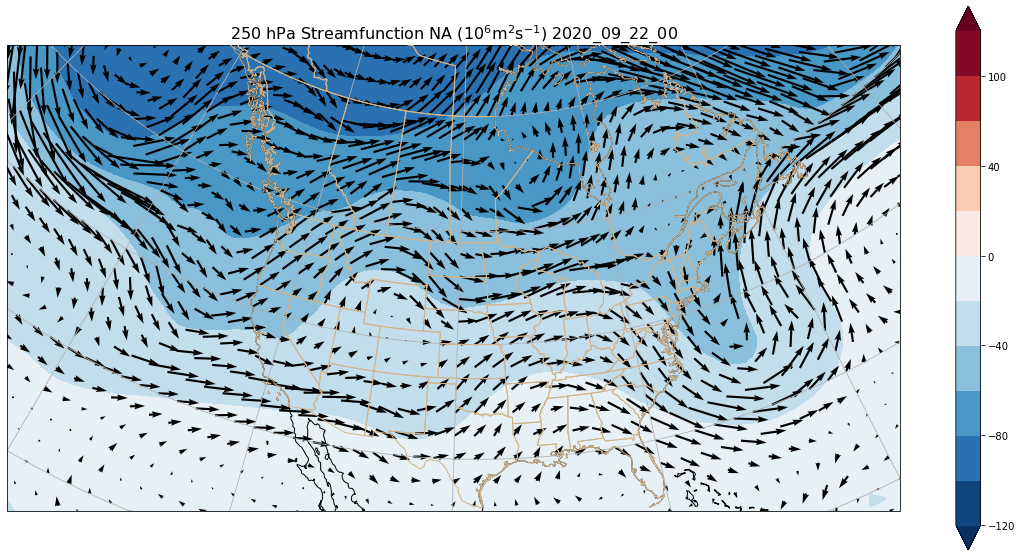

In [12]:
                            
plt.figure(figsize=(20,10))
ax3 = plt.axes(projection=mapcrs)
ax3.set_extent([-140,-60,20,60])
clevs = [ -120, -100, -80, -60, -40,-20, 0, 20, 40, 80, 100, 120]
sf_fill = ax3.contourf(lons_c, lats, sfc * 1e-06, clevs,
                       transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r,
                       extend='both')
#plot every 3rd wind vector
#for 2d arrays
skip=(slice(None,None,2),slice(None,None,2))
#for 1d arrays
skip1 = (slice(None,None,2))
plt.quiver(lonst[skip1],latst[skip1],upsit[skip],vpsit[skip],scale=75, scale_units='inches',pivot='tail',color='black',transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.add_feature(states,edgecolor='tan',zorder=99)
ax3.gridlines()
plt.colorbar(sf_fill, orientation='vertical')
plt.title('250 hPa Streamfunction NA ($10^6$m$^2$s$^{-1}$) %s' % date_time, fontsize=16)
plot_file = '../figs/gfs_na_250_streamfunction_' + date_time
plt.savefig(plot_file)
plt.show()

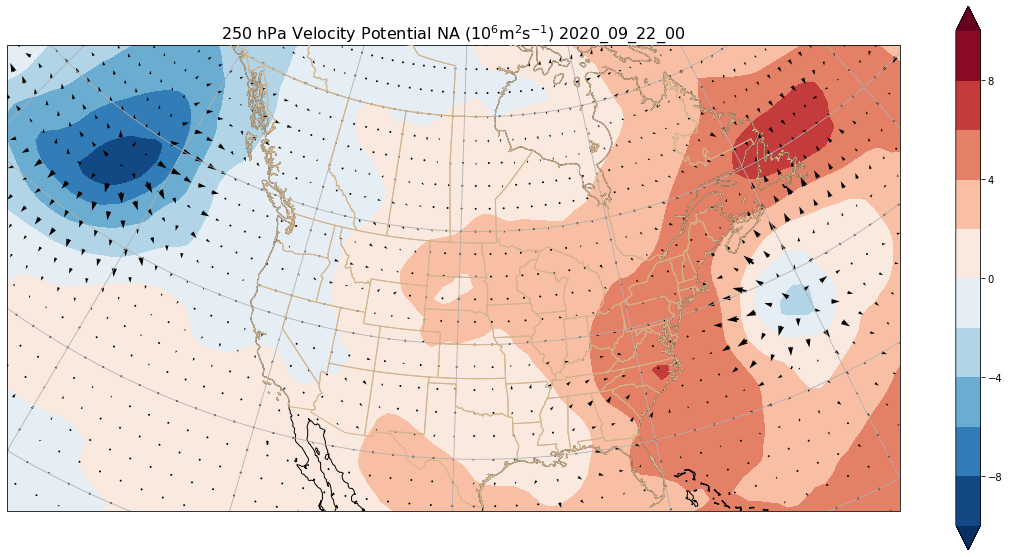

In [13]:
plt.figure(figsize=(20,10))
ax4 = plt.axes(projection=mapcrs)
ax4.set_extent([-140,-60,20,60])
clevs = [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10]
vp_fill = ax4.contourf(lons_c, lats, vpc * 1e-06, clevs,
                       transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r,
                       extend='both')
#plot every 3rd wind vector
#for 2d arrays
skip=(slice(None,None,2),slice(None,None,2))
#for 1d arrays
skip1 = (slice(None,None,2))
plt.quiver(lonst[skip1],latst[skip1],uchit[skip],vchit[skip],scale=75, scale_units='inches',pivot='tail',color='black',transform=ccrs.PlateCarree())
ax4.coastlines()
ax4.add_feature(states,edgecolor='tan',zorder=99)
ax4.gridlines()
plt.colorbar(vp_fill, orientation='vertical')
plt.title('250 hPa Velocity Potential NA ($10^6$m$^2$s$^{-1}$) %s' % date_time, fontsize=16)
plot_file = '../figs/gfs_na_250_vpotential_' + date_time
plt.savefig(plot_file)
plt.show()